In [1]:
from BudgetOptimization import (
    SaturationCurve,
    OptimizationConstraint,
    BudgetOptimizer_NLOPT
)
from pathlib import Path
import pandas as pd
import os

In [2]:
# DATAPATH = Path.cwd()/"PlannerDataset"
DATAPATH = Path("/home/lzhao/PlannerDataset/HILSP")

In [3]:
activity_groups = pd.read_csv(DATAPATH/'activity_groups.csv')
hierarchy = pd.read_csv(DATAPATH/'hierarchy.csv')
kpis = pd.read_csv(DATAPATH/'kpis.csv') # merge kpi
periods = pd.read_csv(DATAPATH/"periods.csv")
data = pd.read_csv(DATAPATH/'data_sum.csv')

In [113]:
def process_planner_dataset(folder = DATAPATH):
    activity_groups = pd.read_csv(folder/'activity_groups.csv')
    activity_groups = activity_groups[activity_groups['Base'] != 1].copy()
    hierarchy = pd.read_csv(folder/'hierarchy.csv')
    kpis = pd.read_csv(folder/'kpis.csv') # merge kpi
    periods = pd.read_csv(folder/"periods.csv")
    data = pd.read_csv(folder/'data_sum.csv')
    data['curveCoefC'] = data['curveCoefC'].fillna(data['proxyCurveCoefC'])
    data['curveCoefD'] = data['curveCoefD'].fillna(data['proxyCurveCoefD'])
    data['AvgWeeklySupportAMP'] = data['proxyAvgWeeklySupportAMP']
    data['WeeksOnAir'] = data['proxyWeeksOnAir']
    data['RetentionRate'] = data['proxyRetentionRate']
    dataset = pd.merge(data, periods, left_on='PeriodId', right_on='Id', how='left').merge(hierarchy, left_on='HierarchyId', right_on='Id', how='left').merge(activity_groups, left_on='ActivityGroupId', right_on='Id', how='left').merge(kpis, left_on='KpiId', right_on='ID', how='left')
    columns = ['Activity Group', 'Product','AggregateName','spend','KpiName', 'kpiValue','activity','WeeksOnAir','RetentionRate','curveCoefC', 'curveCoefD', 'AvgWeeklySupportAMP']
    dataset = dataset[columns].copy().query("kpiValue!=0")
    dataset['enable_curve'] = True
    dataset.loc[dataset['curveCoefC'].isnull(),'enable_curve'] = False
    return dataset

def create_channels(dataset, period, product, kpiname):
    model_dataset = dataset.query(f"AggregateName=='{period}'").query(f"Product=='{product}'").query(f"KpiName=='{metric}'").copy() # add kpi
    channels = {}
    for _, row in model_dataset.iterrows():
        if isinstance(row['Activity Group'], str):
            channel = SaturationCurve(
                spend = row['spend'],
                activity = row['activity'],
                contribution = row['kpiValue'],
                retention_rate = row['RetentionRate'],
                weeksonair=row['WeeksOnAir'],
                AMPWeeklySupport=row['AvgWeeklySupportAMP'],
                c = row['curveCoefC'],
                d = row['curveCoefD'],
                enable_curve=row['enable_curve']
            )
            channels[row['Activity Group']] = channel
    return channels

In [148]:
dataset = process_planner_dataset(folder=DATAPATH)
period = 'CY 2024'
product = 'Total Hills'
metric = "Margin"
dataset = dataset.query("AggregateName==@period").query("Product==@product").query(f"KpiName=='{metric}'")
channels = create_channels(dataset=dataset, period=period, product=product, kpiname=metric)

In [149]:
dataset

,Activity Group,Product,AggregateName,spend,KpiName,kpiValue,activity,WeeksOnAir,RetentionRate,curveCoefC,curveCoefD,AvgWeeklySupportAMP,enable_curve
2660,NaN,Total Hills,CY 2024,1.000000e-04,Margin,8.684247e+08,100.0,NaN,NaN,NaN,NaN,NaN,False
2680,Addressable TV - Masterbrand,Total Hills,CY 2024,4.968633e+07,Margin,1.252752e+08,2062398.7,20.0,0.85,-0.00025,1.8,18.0,True
2700,Addressable TV - PD Equity,Total Hills,CY 2024,8.214916e+06,Margin,1.766500e+07,344503.6,20.0,0.85,-0.00025,1.8,30.0,True
2720,Amazon Digital,Total Hills,CY 2024,9.495786e+06,Margin,1.670899e+07,4004099.7,NaN,NaN,NaN,NaN,NaN,False
2740,Amazon RLM,Total Hills,CY 2024,1.256095e+07,Margin,1.085832e+07,100.0,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3892,PTC Hills-Led Media,Total Hills,CY 2024,1.561074e+06,Margin,9.334650e+05,14628126.5,NaN,NaN,NaN,NaN,NaN,False
3912,PMT Hills-Led Media,Total Hills,CY 2024,3.784091e+05,Margin,1.843173e+05,27468.2,NaN,NaN,NaN,NaN,NaN,False
3932,CTV - Hulu - Switchers,Total Hills,CY 2024,2.595713e+06,Margin,5.040557e+06,83705.4,20.0,0.85,-0.00025,1.8,30.0,True
3952,PR,Total Hills,CY 2024,5.701710e+05,Margin,1.060098e+06,17331172.4,NaN,NaN,NaN,NaN,NaN,False


In [115]:
periods

,LevelId,LevelName,LevelSortOrder,Id,AggregateName,AggregateSortOrder
0,1,Year,0,5,CY 2024,0
1,2,Quarter,1,1,Q1 2024,1
2,2,Quarter,1,2,Q2 2024,2
3,2,Quarter,1,3,Q3 2024,3
4,2,Quarter,1,4,Q4 2024,4


In [116]:
kpis

,KpiName,ID,SortOrder,EfficiencyMetric,OptimizationObjective,Multiplier
0,Margin,1,1,roi,Maximize,1.0
1,Volume (Lbs),2,3,roi,Maximize,1.0
2,Households,3,2,roi,Maximize,1000.0
3,Net Sales,4,4,roi,Maximize,1.0


In [117]:
hierarchy

,Id,SortOrder,LevelId,ParentId,Enabled,Product
0,1,3,2,3,1,SD
1,2,2,2,3,1,PD
2,3,1,1,0,1,Total Hills


In [118]:
dataset = process_planner_dataset(folder=DATAPATH)
dataset['Activity Group'].unique()

array([nan, 'Addressable TV - Masterbrand', 'Addressable TV - PD Equity',
       'Amazon Digital', 'Amazon RLM', 'Amazon Search', 'Amazon VPC',
       "Chewy Hill's-Led Media", 'Chewy Promos', 'Chewy RLM',
       'Consumer Print - Masterbrand', 'CTV - Hulu - Masterbrand',
       'CTV - Hulu - PD Equity', 'CTV - Hulu - Weight',
       'CTV - Other - Masterbrand', 'Digital Display - Masterbrand',
       'Digital Display - PD Handraiser',
       'Digital Display - SD Handraiser', 'Digital Display - Weight',
       'Linear TV - Masterbrand', 'NPPP Kits',
       'Paid Search - Masterbrand', 'Paid Search - PD',
       'Paid Search - SD', 'Paid Social - Masterbrand',
       'Paid Social - Other', 'Paid Social - PD Equity',
       'Paid Social - PD Handraiser', 'Paid Social - SD Equity',
       'Paid Social - SD Handraiser', 'Paid Social - Weight',
       'PD Chewy RLM', 'PD Coupons', 'PD Professional Digital',
       'PD Professional Print', 'PD Professional Social', 'PD Promotions',
       '

In [147]:
dataset = process_planner_dataset(folder=DATAPATH)
period = 'CY 2024'
product = 'Total Hills'
metric = "Margin"
dataset.query(f"AggregateName=='{period}'").query(f"Product=='{product}'").query(f"KpiName=='{metric}'")

,Activity Group,Product,AggregateName,spend,KpiName,kpiValue,activity,WeeksOnAir,RetentionRate,curveCoefC,curveCoefD,AvgWeeklySupportAMP,enable_curve
2660,NaN,Total Hills,CY 2024,1.000000e-04,Margin,8.684247e+08,100.0,NaN,NaN,NaN,NaN,NaN,False
2680,Addressable TV - Masterbrand,Total Hills,CY 2024,4.968633e+07,Margin,1.252752e+08,2062398.7,20.0,0.85,-0.00025,1.8,18.0,True
2700,Addressable TV - PD Equity,Total Hills,CY 2024,8.214916e+06,Margin,1.766500e+07,344503.6,20.0,0.85,-0.00025,1.8,30.0,True
2720,Amazon Digital,Total Hills,CY 2024,9.495786e+06,Margin,1.670899e+07,4004099.7,NaN,NaN,NaN,NaN,NaN,False
2740,Amazon RLM,Total Hills,CY 2024,1.256095e+07,Margin,1.085832e+07,100.0,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3892,PTC Hills-Led Media,Total Hills,CY 2024,1.561074e+06,Margin,9.334650e+05,14628126.5,NaN,NaN,NaN,NaN,NaN,False
3912,PMT Hills-Led Media,Total Hills,CY 2024,3.784091e+05,Margin,1.843173e+05,27468.2,NaN,NaN,NaN,NaN,NaN,False
3932,CTV - Hulu - Switchers,Total Hills,CY 2024,2.595713e+06,Margin,5.040557e+06,83705.4,20.0,0.85,-0.00025,1.8,30.0,True
3952,PR,Total Hills,CY 2024,5.701710e+05,Margin,1.060098e+06,17331172.4,NaN,NaN,NaN,NaN,NaN,False


# specific channel

In [120]:
channel_name = 'Addressable TV - Masterbrand'

In [121]:
channels[channel_name].spend

49686325.1

In [122]:
channels[channel_name].calculate_optimal_spend()

43335030.08971973

In [123]:
channels[channel_name].calculate_contribution(channels[channel_name].spend)

125275220.57

In [124]:
channels[channel_name].calculate_roi(channels[channel_name].spend)

2.52132191941883

In [125]:
channels[channel_name].calculate_marginal_roi(channels[channel_name].spend)

2.1032243967056274

0

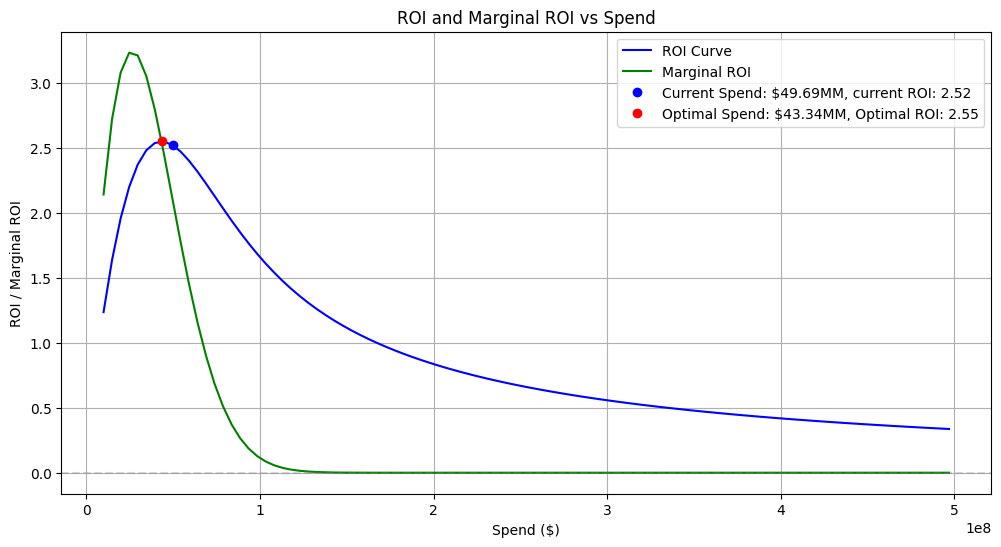

In [126]:
channels[channel_name].plot_roi_curve()

# simulation

In [127]:
channels[channel_name].calculate_roi(channels[channel_name].spend * 1.1)

2.467254595986078

In [128]:
channels[channel_name].calculate_contribution(channels[channel_name].spend * 1.1)

134847695.35669678

# optimization to budget

In [129]:
total_budget = sum([curve.spend for _, curve in channels.items()])

In [131]:
# Scenario 1 Flat Budget
Optimizer = BudgetOptimizer_NLOPT(channels)
constraints_df = pd.read_csv(DATAPATH/'constrain template.csv', index_col='Driver')
results = Optimizer.optimize(scenario='OptimizeToSpend', constraints_df=constraints_df)

In [143]:
for channel, curve in channels.items():
    results.loc[channel, 'current spend'] = curve.spend
    results.loc[channel, 'spend diff'] = (results.loc[channel, 'spend'] - curve.spend) / curve.spend

In [144]:
results['spend'].sum()

511202354.97

In [145]:
results['current spend'].sum()

511202354.96999997

In [146]:
results

,spend,contribution,roi,current spend,spend diff
Addressable TV - Masterbrand,5.962359e+07,1.427230e+08,2.393734,49686325.10,0.200000
Addressable TV - PD Equity,6.892839e+06,1.677808e+07,2.434132,8214915.90,-0.160936
Amazon Digital,1.139494e+07,2.005079e+07,1.759622,9495785.90,0.200000
Amazon RLM,1.004876e+07,8.686658e+06,0.864451,12560951.10,-0.200000
Amazon Search,1.351999e+07,2.204105e+07,1.630256,11266661.30,0.200000
...,...,...,...,...,...
PTC Hills-Led Media,1.248859e+06,7.467720e+05,0.597963,1561074.06,-0.200000
PMT Hills-Led Media,3.027273e+05,1.474539e+05,0.487085,378409.11,-0.200000
CTV - Hulu - Switchers,2.115735e+06,4.730488e+06,2.235860,2595713.27,-0.184912
PR,6.842052e+05,1.272118e+06,1.859264,570170.98,0.200000


In [57]:
# Scenario 2 Flat Budget with Bundle constraints
Optimizer = BudgetOptimizer_NLOPT(channels)
bundle_constraint_1 = OptimizationConstraint(['CTV - Hulu - Masterbrand', 'CTV - Hulu - PD Equity', 'CTV - Hulu - SD Equity', 'CTV - Hulu - Weight'], 7589459, 7589459)
bundle_constraint_2 = OptimizationConstraint(['Paid Search - Masterbrand', 'Paid Search - PD', 'Paid Search - SD'], 4038223, 4038223)
bundle_constraints = [bundle_constraint_1, bundle_constraint_2]
# bundle_constraints = []
# for channel, curve in channels.items():
#     if 'PM' not in channel:
#         bundle_constraints.append(OptimizationConstraint([channel], curve.spend, curve.spend))
constraints_df = pd.read_csv(DATAPATH/'constrain template.csv', index_col='Driver')
results = Optimizer.optimize(scenario='OptimizeToSpend', constraints_df=constraints_df, bundle_constraints=bundle_constraints)

In [59]:
for channel, curve in channels.items():
    results.loc[channel, 'current spend'] = curve.spend

In [60]:
results

,spend,contribution,roi,current spend
BM-Digital&OTV,5.350325e+06,9.949428e+06,1.859593,5.350325e+06
BM-IP Coop,1.568893e+06,6.389248e+06,4.072457,1.568893e+06
BM-OOH,6.702412e+05,6.107936e+06,9.113042,6.702412e+05
PM-Affiliate APP,1.375642e+06,5.727976e+06,4.163855,1.375642e+06
PM-Affiliate Non APP,3.212395e+06,1.550278e+07,4.825927,3.423362e+06
PM-Apple Search Ads,9.793076e+05,5.727976e+06,5.849007,9.793076e+05
PM-Paid Search Brandzone,6.214361e+05,7.941127e+06,12.778671,5.178634e+05
PM-Paid Search Keyword,5.551759e+04,7.335410e+06,132.127673,5.551759e+04
PM-Paid Search APP,5.941437e+05,5.727976e+06,9.640725,5.941437e+05
PM-Paid Social,1.163977e+05,7.631620e+06,65.565022,9.699811e+04


In [33]:
# Scenario 3 Optimize to target KPI
Optimizer = BudgetOptimizer_NLOPT(channels)
constraints_df = pd.read_csv(DATAPATH/'constrain template.csv', index_col='Driver')
constraints_df['Minimum Spend'] = 80
constraints_df['Maximum Spend'] = 120
results = Optimizer.optimize(scenario='OptimizeToKPITarget', constraints_df=constraints_df,  target_kpi=190540270)